# **Project: Asset Replacement with Maintenance**



   At the beginning of each year, a manufacturer must decide wheter to continue to operate an aging physical asset or replace it with a new one. If he keep the current asset, he must decide whether to perform annual service maintenance to prevent the asset from failing. An asset that is $s$ years old yields a profit contribution $p(s)$ up to $n=5$ years, at which point the asset becomes unsafe and must be replaced by law. An asset that is $s$ years old and has been maintained $m$ times fails with probability $\mu(s,m)$ and yields a proft of 0 in that year. The cost of a new asset is $c = 75$ and the cost of of servicing an asset is $k=10$.

  What replacement-maintenance policy maximizes profits?

## **Model**

This is an infinite horizon deterministic model with time $t$ measured
in years.

The age is a discrete state variable:
- $s \in \{0, 1, 2, 3, 4, 5\}$

The variable $maint$ is the number of times that the maintenance of asset is failed:
- $m \in \{0, 1, 2, 3, 4 \}$


The action variable $a$ is the keep-replacement-maintenance decision:
- $a =  \begin{cases}
  0,  & \text{ keep the asset, perform no maintenance}\\
  1,  & \text{ keep the asset, perform the maintenace}\\
  2,  & \text{ replace the asset}
  \end{cases}$




The state transition function is:
- $t(s, a) = \begin{cases}
  s+1,  & a = \text{ keep}\\
  1, & a = \text{ replace}
  \end{cases}$
  
The maintenance transition function is:
 - $t(m, a, s) = \begin{cases}
  m,  & a = 0 ,  \text{keep the asset but perform no maintenance}\\
  m,  & a = 1,   \text{keep the asset, perform the maintenac, which succeeds with the probability of}  1- \mu(s,m) \\
  m+1,  & a = 1,  \text{keep the asset, perform the maintenace, which fails with the probability of} \mu(s,m) \\
  0, & a =2,  \text{ replace the asset}
  \end{cases}$
  
 
The reward function is:
- $r(s, a, s, m) = \begin{cases}
  p(s) , & a = 0 ,  \text{keep the asset but perform no maintenance}\\
  p(s) - k, &  a = 1,   \text{keep the asset, perform the maintenace, which succeeds with the probability of}  1- \mu(s,m)\\
  0 - k & a = 1,  \text{keep the asset, perform the maintenace, which fails with the probability of} \mu(s,m) \\
  p(0)- c, & a =2,  \text{ replace the asset}
\end{cases}$

where $p(s) = 50 - 2.5\cdot s - 2.5\cdot s^2$. 

# **Environment**

In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [653]:
class AssetReplacementEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(AssetReplacementEnv, self).__init__()

        n_actions = 3
        self.action_space = spaces.Discrete(n_actions)

        # With spaces.Tuple you can create a multidimensional state
        # In our simple model observation and state are synonyms
        self.n_states = 6
        self.observation_space = spaces.Discrete(self.n_states)

        self.n_maint = 5
        self.maint_space = spaces.Discrete(self.n_maint)
        
        self.service = 10
        self.cost = 75
        self.rng = default_rng()
        
        
    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
#%%%%%
        mu = (self.state - self.maint) / 5
    
        # calculate the reward and the state transition
        if action == 2:                                    
            reward = self.profit(0) - self.cost         # replace
            self.state = 1 
            self.maint = 0
        
        elif action == 1:
           
            if self.rng.random() < mu:      # maintenance fail
                reward = 0 - self.service
                self.maint += 1
                self.state += 1 
            else:    
                reward = self.profit(self.state) - self.service  #maintenace success
                self.state += 1 

        else:
            reward = self.profit(self.state)          # no maintenance
            self.state += 1 
            
    #%%%%%     


        # This is a continuing task, so done is always false
        done = False

        info = {}
       #print("m:" + str(self.maint))
        return self.state, self.maint, reward, done, info


    def profit(self, state):
        return 50 - 2.5*state - 2.5*state**2
        

    def reset(self):
        # set initial state (age of machine) to 0
        self.state = 0
        self.maint = 0            
 #%%%%5
        return self.state, self.maint
   
    def sumprofit(self, state_path, maint_path, action_path, timesteps):
        sumprofit = 0
    
        for i in range(timesteps):
            # calculate the reward and the state transition
            reward = 0
            if action_path[i] == 2:                                    
                reward = self.profit(0) - self.cost         # replace

            elif action_path[i] == 1:
                if i > 0:
                    if  maint_path[i] - maint_path[i-1] > 0:     # maintenance failed in that simulation
                        reward = 0 - self.service
                    else:    
                        reward = self.profit(state_path[i]) - self.service  #maintenace success
            else:
                reward = self.profit(self.state)          # no maintenance
            
            #print('profit year -' + str(i) + ':'+ str(reward))
            sumprofit+= reward
       
        return sumprofit  
                


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

# **Dynamic Programming**

In [4]:
env = AssetReplacementEnv()

n_actions = env.action_space.n
epsilon = 0.05
discount = 0.9

state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]


for t in range(timesteps):
    state, maint, reward, _, _ = env.step(action)
    
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

NameError: name 'agent' is not defined

## **Policy Evaluation**

In [5]:
def evaluate_policy(env, V, action, gamma, eps=1e-8, max_iter=1000):
    """Implements the policy evaluation algorithm
    
    Calculates the corresponding value function of a policy

    Args:
        env (class): AssetManagement Environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (float): Discount factor
        eps (float): Error tolerance for stopping the iteration
        max_iter (int): Maximum number of iteration if process doesn't converge

    Returns:
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
    
    """

     for i in range(max_iter):
        # save value function to check for convergence later
        V_old = V.copy()

        # one iteration step for all states
        states = np.arange(n_states)
        maint = mp.arrange(n_maint)
        V = env.step(action)+ gamma * V[states - policy]
        ### END OF YOUR CODE ###

        # check for convergence
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    
    return V   


IndentationError: unexpected indent (<ipython-input-5-94accbcf195f>, line 22)

In [ ]:




# create environment and reset it
env = MineManagementEnv()
env.reset()


   

# init value function
V = defaultdict(lambda: np.zeros(self.n_actions))
# define policy to evaluate, i.e.always keep the asset without maintenance until it reach state year 3 and replace it

for states in range(n_state)



# discount factor
gamma = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy, gamma)


# **Sarsa Agent**

In [3]:
class SarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        
        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))         
       
    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

        # perform update
        target = reward + self.discount*self.q[state, maint][action]
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error
        

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy.

        Args:
            state (int): Current state, i.e. age of asset.

        Returns:
            action (int): Action the agent takes.
        """

        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
 #%%%%
        if state== 5 or maint == 4:                           # two expression are actually equivalent  
            return 2
        
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action
        
 
    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """
        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)
#         print(ties)
#         print("argmax index:" + str(index))
        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): intial times of maintenance failure
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action
    




In [515]:
env = AssetReplacementEnv()

n_actions = env.action_space.n
epsilon = 0.5
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 1000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
#     print('Episodes-'+ str(i)+'-Q value')
#     print(agent.q)    


---

**Evaluation**


---


In [518]:
# the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# so it is quite convincing for the evaluation of the agent
n_avg = 1000
sum_prof = 0
for i in range(n_avg):
    sum_period = 0
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
        state_path.append(state)
        maint_path.append(maint)
        action_path.append(action)
    
    sum_period = env.sumprofit(state_path, maint_path, action_path, timesteps)
    #print('20 year sum: '+ str(sum_period))
    sum_prof += sum_period

avg_prof = sum_prof/n_avg
avg_prof
print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

Sum of 20 years profit averaged by another 1000 simulation:272.42


In [513]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_prof]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.7,0.2,0.9,261.56


In [274]:
#df_stepsize = df_parper
#df_discount = df_parper

In [237]:
#df_discount_all = df_discount

In [167]:
#df_stepsize_all = df_stepsize

In [275]:
df_discount_all = df_discount_all.append(df_discount,ignore_index=True)
df_discount_all

,epsilon,step_size,discount,performance
0,0.2,0.2,0.90,224.000
0,0.2,0.2,0.80,208.985
0,0.2,0.2,0.70,190.525
0,0.2,0.2,0.95,232.710


In [220]:
df_stepsize_all =  df_stepsize_all.append(df_stepsize,ignore_index=True)
df_stepsize_all

,epsilon,step_size,discount,performance
0,0.2,0.05,0.9,205.930
1,0.2,0.10,0.9,220.945
2,0.2,0.20,0.9,221.790
3,0.2,0.30,0.9,220.685


In [456]:
#df_parper_all = df_parper

In [514]:
df_parper_all = df_parper_all.append(df_parper,ignore_index=True)
df_parper_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,101.96
1,0.10,0.2,0.9,170.54
2,0.20,0.2,0.9,233.18
3,0.40,0.2,0.9,258.38
4,0.50,0.2,0.9,266.96
5,0.60,0.2,0.9,260.78
6,0.70,0.2,0.9,261.56



---

**Plot one simulation of best performance**


---

In [540]:
# Perform path simulation of episode:  n_episode+1
state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]


for t in range(timesteps):
    state, maint, reward, _, _ = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [541]:
performance = env.sumprofit(state_path, maint_path, action_path, timesteps)
print('Performance of the simulation is: ' + str(performance))

performance of simulation is: 305.0


In [542]:
# extract the value function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action


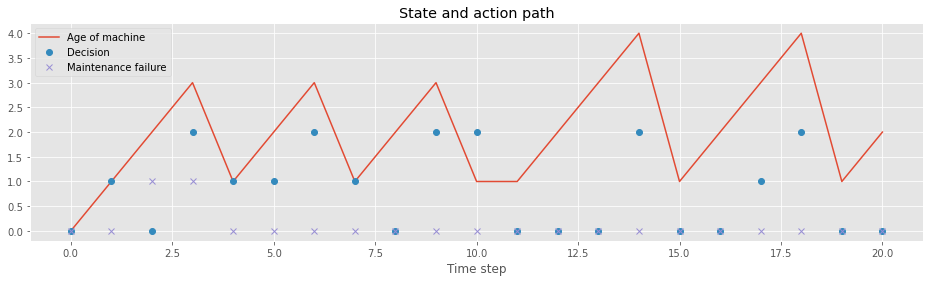

In [543]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('SARSA_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

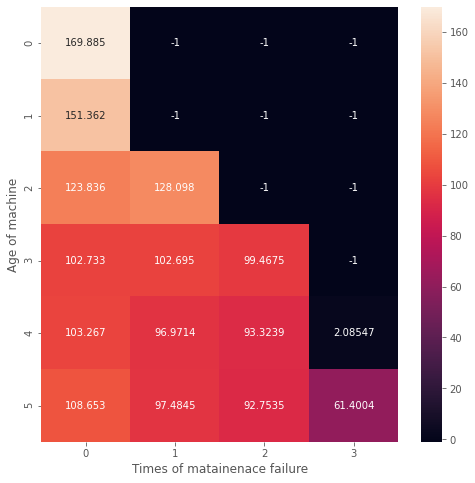

In [544]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

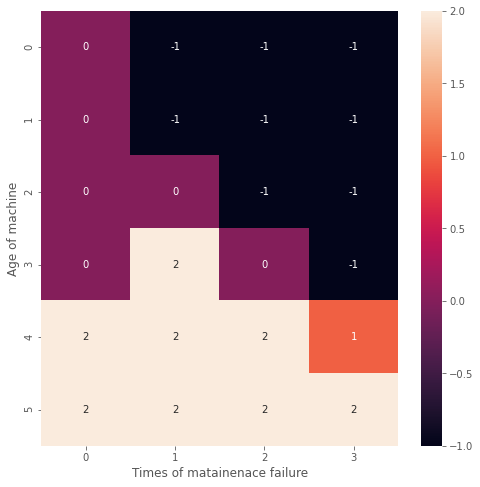

In [545]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('SARSA_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

# **Q-Learning Agent**

In [300]:
class QLearningAgent():
    def __init__(self, agent_info):
        """Initialize Agent

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """
        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))      


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

  
        # perform update
        target = reward + self.discount* np.max(self.q[state, maint])
        td_error = target- self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error
     

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
        if state== 5 or maint == 4:
            return 2
        
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_maint= maint
        self.previous_state = state
        self.previous_action = action

        return action


In [546]:
env = AssetReplacementEnv()

n_actions = env.action_space.n
epsilon = 0.5
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 1000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)
  
    for t in range(timesteps):
        state, maint, reward, _, _ = env.step(action)
        action = agent.step(reward, state, maint)



---

**Evaluation**


---


In [551]:
# the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# so it is quite convincing for the evaluation of the agent
n_avg = 1000
sum_prof = 0
for i in range(n_avg):
    sum_period = 0
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
        state_path.append(state)
        maint_path.append(maint)
        action_path.append(action)
    
    sum_period = env.sumprofit(state_path, maint_path, action_path, timesteps)
    #print('20 year sum: '+ str(sum_period))
    sum_prof += sum_period

avg_prof = sum_prof/n_avg
avg_prof
print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

Sum of 20 years profit averaged by another 1000 simulation:210.68


In [424]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_prof]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.5,0.4,0.9,187.21


In [382]:
df_epsilon = df_parper

In [307]:
#df_epsilon_all = df_epsilon

In [ ]:
df_epsilon_all = df_epsilon_all.append(df_epsilon, ignore_index = True)
df_epsilon_all

In [385]:
df_epsilon_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,-20.530
1,0.10,0.2,0.9,58.705
2,0.20,0.2,0.9,135.925
3,0.30,0.2,0.9,171.350
5,0.40,0.2,0.9,184.220
6,0.50,0.2,0.9,196.635
7,0.60,0.2,0.9,192.995
9,0.70,0.2,0.9,194.360


In [425]:
df_stepsize = df_parper


In [396]:
#df_stepsize_all = df_stepsize

In [426]:
df_stepsize_all =  df_stepsize_all.append(df_stepsize,ignore_index=True)
df_stepsize_all

,epsilon,step_size,discount,performance
0,0.5,0.1,0.9,188.640
1,0.5,0.2,0.9,198.195
2,0.5,0.3,0.9,195.205
3,0.5,0.4,0.9,187.210


Summary:  step_size matter not really when it is small, so just take 0.2
          epsilon: around 0.2 the best
          disount: higher seems to be better, but the task require it to be 0.9



---

**Plot one simulation of best performance**


---


In [705]:
# Perform path simulation
state, maint = env.reset()

#agent.epsilon = 0
action = agent.start(state, maint)


state_path = [state]
maint_path = [maint]
action_path = [action]

timesteps = 20

for t in range(timesteps):
    state, maint, reward, done, _ = env.step(action)
    action = agent.step(reward, state, maint)
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [706]:
performance = env.sumprofit(state_path, maint_path, action_path, timesteps)
print('Performance of the simulation is: ' + str(performance))

Performance of the simulation is: 210.0


In [707]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    action = np.argmax(values)
    policy[state_maint] = action
    V[state_maint] = value


In [693]:
V

defaultdict(float,
            {(0, 0): 130.77925107898366,
             (1, 0): 108.75096406436681,
             (2, 0): 82.14870684961697,
             (2, 1): 82.72614991609139,
             (3, 0): 56.443419972972485,
             (3, 1): 56.80089812952771,
             (3, 2): 57.31834851093558,
             (4, 0): 56.122633757883364,
             (4, 1): 56.42220303893052,
             (4, 2): 57.95699062174867,
             (4, 3): 12.133164562839127,
             (5, 0): 56.5452409400734,
             (5, 1): 55.96906947188383,
             (5, 2): 56.951661729761646,
             (5, 3): 56.35446856943293})

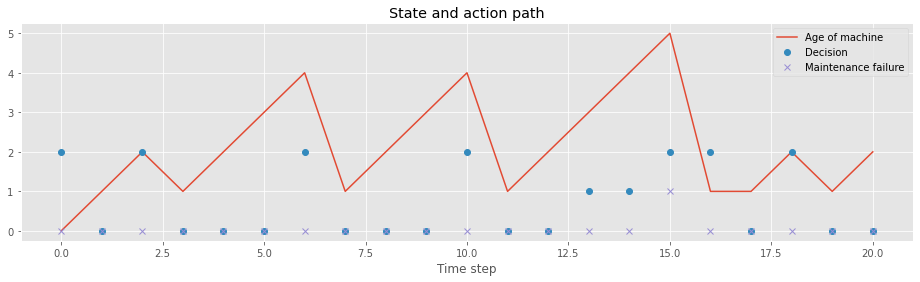

In [708]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('QLearning_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


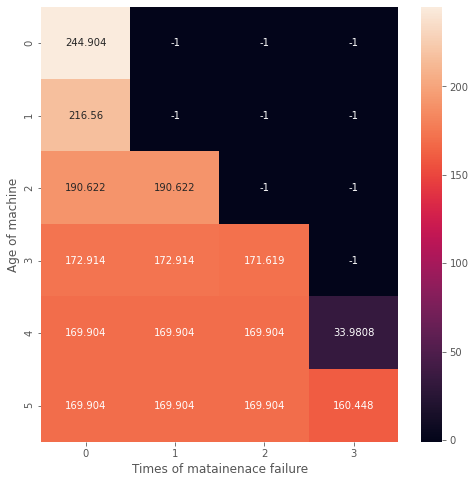

In [561]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('Qlearning_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

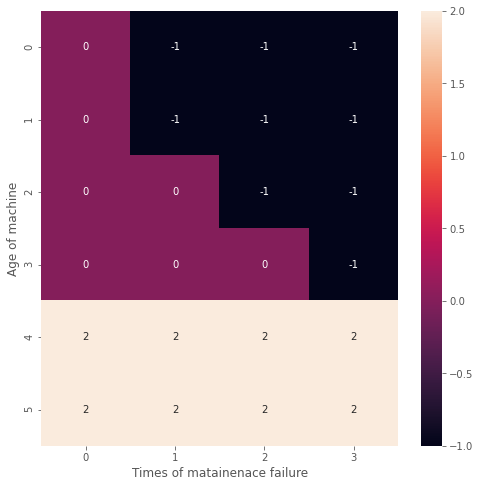

In [562]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('Qlearning_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

# **Expected Sarsa**

In [718]:
class ExpectedSarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))        


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

         # choose action using epsilon greedy policy
        action = self.select_action(state, maint)  

        # perform update
        policy = np.ones(self.n_actions)*self.epsilon/self.n_actions
        policy[np.argmax(self.q[state, maint])] += 1 - self.epsilon

       # matrix-vector multiplication
        expectation = self.q[state, maint] @ policy


        target = reward + self.discount * expectation
        td_error = target - self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error



        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        if state == 5 or maint == 4:
            return 2

        current_q  = self.q[state, maint]
      
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(self.n_actions)
        else:
            action = self.argmax(current_q)

        return action
        

    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

In [799]:
env = AssetReplacementEnv()

num_actions = env.action_space.n
epsilon = 0.5
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = ExpectedSarsaAgent(agent_info)


n_episodes = 1000
timesteps = 20

for _ in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward, _, _ = env.step(action)
        action = agent.step(reward, state, maint)



---

**Evaluation**


---

In [801]:
# the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# so it is quite convincing for the evaluation of the agent
n_avg = 1000
sum_prof = 0
for i in range(n_avg):
    sum_period = 0
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
        state_path.append(state)
        maint_path.append(maint)
        action_path.append(action)
    
    sum_period = env.sumprofit(state_path, maint_path, action_path, timesteps)
    #print('20 year sum: '+ str(sum_period))
    sum_prof += sum_period

avg_prof = sum_prof/n_avg
avg_prof
print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

Sum of 20 years profit averaged by another 1000 simulation:158.41


In [796]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_prof]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.7,0.2,0.9,138.775


In [797]:
df_epsilon = df_parper

In [731]:
#df_epsilon_all = df_epsilon

In [798]:
df_epsilon_all = df_epsilon_all.append(df_epsilon, ignore_index = True)
df_epsilon_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,-60.930
1,0.10,0.2,0.9,-12.200
2,0.20,0.2,0.9,61.555
3,0.30,0.2,0.9,90.375
4,0.40,0.2,0.9,146.365
5,0.50,0.2,0.9,158.740
6,0.60,0.2,0.9,149.830
7,0.70,0.2,0.9,138.775



---

**Plot one simulation of best performance**


---


In [830]:
# Perform path simulation
state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]

for t in range(timesteps):
    state, maint, reward, done, _ = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [831]:
performance = env.sumprofit(state_path, maint_path, action_path, timesteps)
print('Performance of the simulation is: ' + str(performance))

Performance of the simulation is: 235.0


In [832]:
V

defaultdict(float,
            {(0, 0): 130.6810144635827,
             (1, 0): 107.5964539498988,
             (2, 0): 80.96677016187063,
             (2, 1): 82.74936599233739,
             (3, 0): 56.31691948905574,
             (3, 1): 56.750451200830454,
             (3, 2): 57.31834851093558,
             (4, 0): 56.443225414085084,
             (4, 1): 56.00310172247173,
             (4, 2): 57.597446688754154,
             (4, 3): 15.116560632936864,
             (5, 0): 56.47414602717905,
             (5, 1): 55.57370487528717,
             (5, 2): 56.951661729761646,
             (5, 3): 55.989970639691975})

In [833]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action
    

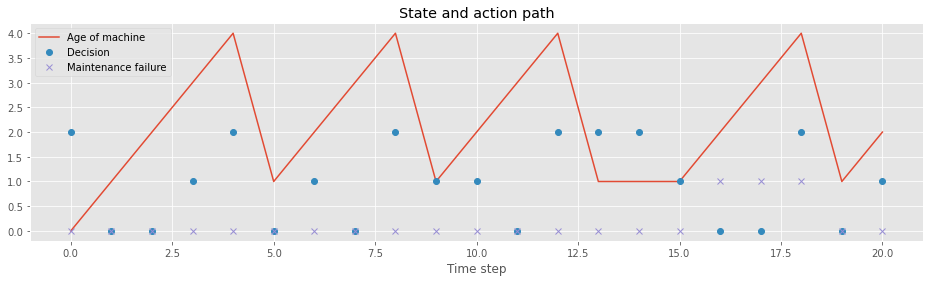

In [835]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('ExSarsa_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


In [34]:
V

defaultdict(float,
            {(0, 0): 84.1222002808312,
             (1, 0): 47.140063537104865,
             (2, 0): 16.050853970239025,
             (2, 1): 39.58283698273672,
             (3, 0): 23.162983296941466,
             (3, 1): 23.766612519509792,
             (3, 2): 16.647856193434432,
             (4, 0): 25.919437153578343,
             (4, 1): 15.263270048004747,
             (4, 2): 20.82652075434692,
             (4, 3): 7.713690573523174,
             (5, 1): 7.7519884973199265,
             (5, 2): 14.818426693101566,
             (5, 3): 12.420384946020565})

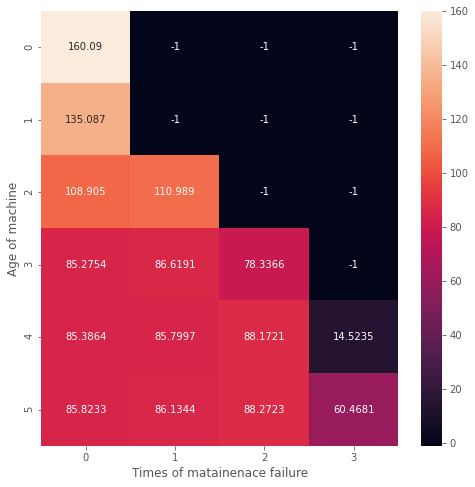

In [837]:

plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

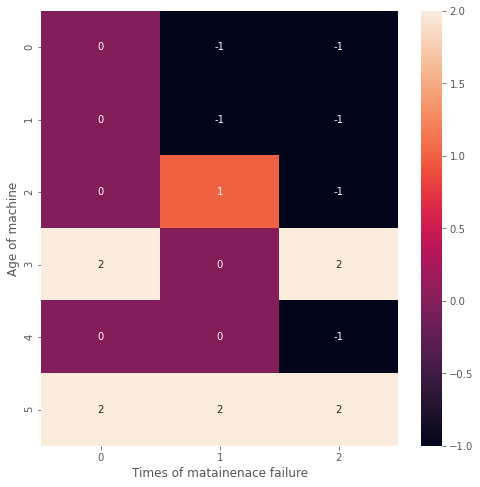

In [103]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

In [34]:
X =  np.array([x[0] for x in list(V.keys())])

In [35]:
Y = np.array([x[1] for x in list(V.keys())])

In [36]:
Z = np.array( list(V.values()))

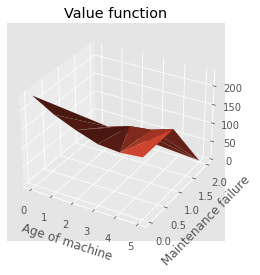

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X,Y,Z)
ax.set_title('Value function')
ax.set_xlabel('Age of machine')
ax.set_ylabel( 'Maintenance failure')
plt.show()